In [8]:
from src.datamodules import ChesapeakeRSCDataModule
from src.modules import CustomSemanticSegmentationTask
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.metrics import recall_score

In [2]:
def get_latest_checkpoint_from_dir(dir):
    largest_epoch = 0
    largest_epoch_fn = None
    for fn in os.listdir(dir):
        if fn.endswith(".ckpt") and fn != "last.ckpt":
            base = os.path.basename(fn)[:-5]
            parts = base.split("-")
            epoch = int(parts[0].split("=")[1])
            if epoch > largest_epoch:
                largest_epoch = epoch
                largest_epoch_fn = fn
    return os.path.join(dir, largest_epoch_fn), largest_epoch

In [3]:
experiment_name_to_dirs = {
    "fcn": "logs/fcn_128_0.001/lightning_logs/version_0/checkpoints/",
    "unet_resnet18": "logs/default_unet_resnet18/lightning_logs/version_0/checkpoints/",
    "unet_resnet50": "logs/default_unet_resnet50/lightning_logs/version_0/checkpoints/",
    "deeplabv3+_resnet18": "logs/default_deeplabv3+_resnet18/lightning_logs/version_0/checkpoints/",
    "deeplabv3+_resnet50": "logs/default_deeplabv3+_resnet50/lightning_logs/version_0/checkpoints/",
}

In [59]:
name_to_pretty_name = {
    "unet_resnet18": "U-Net (ResNet-18)",
    "unet_resnet50": "U-Net (ResNet-50)",
    "fcn": "FCN",
    "deeplabv3+_resnet18": "DeepLabv3+ (ResNet-18)",
    "deeplabv3+_resnet50": "DeepLabv3+ (ResNet-50)",
}

In [4]:
device = torch.device("cuda:3")

In [5]:
dm = ChesapeakeRSCDataModule(
    root="data/ChesapeakeRSC/",
    batch_size=32,
    num_workers=8,
    differentiate_tree_canopy_over_roads=True,
)
dm.setup("test")

In [6]:
def run_eval_on_model(model, device):

    gt_tree_canopy_over_road_predictions_per_patch = []
    gt_tree_canopy_over_road_distances_per_patch = []

    for batch in tqdm(dm.test_dataloader()):
        images = batch["image"].to(device) / 255.0
        masks = batch["mask"].to(device)

        with torch.inference_mode():
            preds = model(images).argmax(dim=1).cpu().numpy()

        for i in range(images.shape[0]):
            mask = masks[i].cpu().numpy()
            tree_canopy_over_road_mask = mask == 2
            if np.any(tree_canopy_over_road_mask):
                distance_to_road = cv2.distanceTransform((~(mask == 1)).astype(np.uint8), cv2.DIST_L1, 3)
                distances_from_tree_canopy_over_road_to_road = distance_to_road[tree_canopy_over_road_mask]
                predictions_for_tree_canopy_over_road = preds[i][tree_canopy_over_road_mask]
                gt_tree_canopy_over_road_distances_per_patch.append(distances_from_tree_canopy_over_road_to_road)
                gt_tree_canopy_over_road_predictions_per_patch.append(predictions_for_tree_canopy_over_road)

    all_tree_canopy_over_road_predictions = np.concatenate(gt_tree_canopy_over_road_predictions_per_patch)
    all_tree_canopy_over_road_distances = np.concatenate(gt_tree_canopy_over_road_distances_per_patch)
    good_idxs = all_tree_canopy_over_road_distances < 8192.0
    all_tree_canopy_over_road_distances = all_tree_canopy_over_road_distances[good_idxs]
    all_tree_canopy_over_road_predictions = all_tree_canopy_over_road_predictions[good_idxs]

    return all_tree_canopy_over_road_predictions, all_tree_canopy_over_road_distances

In [7]:
results_per_name = {}
for name, experiment_dir in experiment_name_to_dirs.items():
    model_fn, epoch = get_latest_checkpoint_from_dir(experiment_dir)
    task = CustomSemanticSegmentationTask.load_from_checkpoint(model_fn, map_location="cpu")
    model = task.model.eval().to(device)

    predictions, distances = run_eval_on_model(model, device)
    results_per_name[name] = (predictions, distances)

100%|██████████| 94/94 [00:28<00:00,  3.25it/s]


In [9]:
for name, (predictions, distances) in results_per_name.items():
    score = recall_score(np.ones_like(predictions), predictions, sample_weight=distances)
    print(f"{name}: {score:0.4f}")

fcn: 0.1069
unet_resnet18: 0.4645
unet_resnet50: 0.4565
deeplabv3+_resnet18: 0.4125
deeplabv3+_resnet50: 0.4614


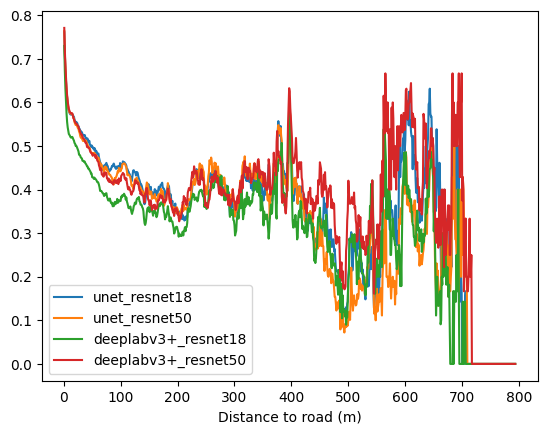

In [43]:
xs_ys_by_name = {}
for name, (predictions, distances) in results_per_name.items():
    if name == "fcn":
        continue
    xs = []
    ys = []
    for i in tqdm(range(1, 794)):
        xs.append(i)
        ys.append(np.mean(predictions[distances == i]))
    xs_ys_by_name[name] = (xs, ys)

plt.figure()
for name, (xs, ys) in xs_ys_by_name.items():
    plt.plot(xs, ys, label=name)
plt.xlabel("Distance to road (m)")
plt.legend()
plt.show()
plt.close()

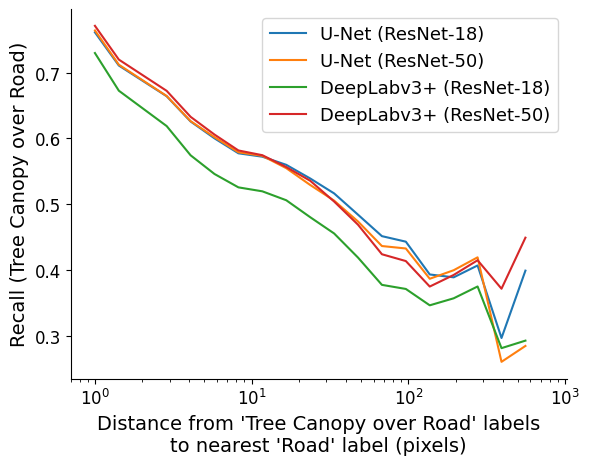

In [83]:
bins = np.logspace(0, np.log10(distances.max()+1), num=20)

xs_ys_by_name = {}
for name, (predictions, distances) in results_per_name.items():
    if name == "fcn":
        continue
    xs = []
    ys = []
    count = 0
    for i in range(0, len(bins)-1):
        vals = predictions[(distances >= bins[i]) & (distances < bins[i+1])]
        if vals.shape[0] == 0:
            continue
        count += vals.shape[0]
        xs.append(bins[i])
        ys.append(np.mean(vals))
    xs_ys_by_name[name] = (xs, ys)

ns = []
for i in range(0, len(bins)-1):
    vals = predictions[(distances >= bins[i]) & (distances < bins[i+1])]
    if vals.shape[0] == 0:
        continue
    ns.append(vals.shape[0])


fig = plt.figure()
ax = plt.gca()
for name, (xs, ys) in xs_ys_by_name.items():
    plt.plot(xs, ys, label=name_to_pretty_name[name])

plt.xlabel("Distance from 'Tree Canopy over Road' labels\nto nearest 'Road' label (pixels)", fontsize=14)
plt.ylabel("Recall (Tree Canopy over Road)", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0.7,1024])
plt.xscale("log")
plt.legend(loc="upper right", fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()
plt.close()

In [1]:
bins

NameError: name 'bins' is not defined